## RandomForest на данных GPS

__Папка с данными на gdrive__

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import shap
from matplotlib import pyplot as plt
from matplotlib import colors
from os import listdir
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from snippets import *

%matplotlib inline

In [2]:
DATA_PATH = "../../data"

GPS_PATH = f"{DATA_PATH}/gps_data_fixed.csv"
ACCEL_PATH = f"{DATA_PATH}/accel_data_fixed.csv"

listdir(DATA_PATH)

['data_good_right_dates',
 'drivers_stats.csv',
 'gps_data.csv',
 'unlabeled',
 'gps_data_raw.csv',
 'matched_routs.csv',
 'matched_routs_fixed.csv',
 'matched_data_fixed.csv',
 'good_data',
 'matched_data.csv',
 'points_stats.csv',
 'proba_rf.csv',
 'gps_data_fixed.csv',
 'submission_rf.csv',
 'accel_data.csv',
 'accel_data_raw.csv',
 'drivers_with_gps_and_sl_problems',
 'accel_data_outlier.csv',
 'gps_stats.csv',
 'submission_catboost.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv',
 'gps_data_outlier.csv',
 'accel_data_fixed.csv',
 'proba_catboost.csv']

In [3]:
df_gps = pd.read_csv(GPS_PATH, parse_dates=[0, 3]) \
    .sort_values(by=["driver_hash", "gps_time"]) \
    .reset_index(drop=True)
describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378774272,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866647296,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
gps_delta,float64,5.05029e+06,1315.76,0.0333333,2,3,3,1.91032e+08,335148
gps_distance,float64,5.05029e+06,28.0507,0,0.1,5.2,24.8,6.45109e+06,6079.83
gps_speed,float64,5.05029e+06,6.47348,0,0,2,9.7,1.29022e+06,874.743
gps_accel,float64,5.05029e+06,0.131191,-258044,-0.115731,0,0.124418,258044,272.817


(5050292, 18)

## Разбивка на поездки

In [4]:
ROUTE_SPLIT_COLUMN = "gps_delta"
ROUTE_SPLIT_INTERVAL = 30

# разбиваю на поездки, если между точками разница больше ROUTE_SPLIT_INTERVAL секунд
df_gps["route_diff"] = pd.to_timedelta(df_gps[ROUTE_SPLIT_COLUMN], unit="seconds") \
    .dt.total_seconds()

df_gps["route_start"] = 0
df_gps.loc[df_gps["route_diff"] > ROUTE_SPLIT_INTERVAL, "route_start"] = 1

df_gps["route_id"] = df_gps["route_start"].cumsum().astype(int)

df_gps[["gps_time", "gps_delta", "route_start", "route_diff", "route_id"]]

,gps_time,gps_delta,route_start,route_diff,route_id
0,2020-11-10 03:08:12,191031533.0,1,191031533.0,1
1,2020-11-10 03:42:48,2076.0,1,2076.0,2
2,2020-11-10 06:38:30,10542.0,1,10542.0,3
3,2020-11-10 06:38:31,1.0,0,1.0,3
4,2020-11-10 06:54:36,965.0,1,965.0,4
...,...,...,...,...,...
5050287,2020-11-25 22:45:39,672.0,1,672.0,21442
5050288,2020-11-25 22:57:52,733.0,1,733.0,21443
5050289,2020-11-25 23:10:27,755.0,1,755.0,21444
5050290,2020-11-26 00:04:35,3248.0,1,3248.0,21445


In [5]:
# [None, -1, 0, 1]
FORCE_FRAUD = None

# Выбор случайного водителя
df_driver, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
# driver_routs = df_driver["route_id"].astype(int)

center = (df_driver["lat"].mean(), df_driver["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

map_driver_points(m, df_driver, driver_hash, label=driver_fraud, color="black", weight=10)

color = df_driver.head(1)["fraud"].replace({1:"red", 0:"green", -1:"blue"}).values[0]

for rx in df_driver["route_id"].unique():
    gps_route = df_driver.loc[df_driver["route_id"] == rx,["lat", "lon"]]
    if gps_route.shape[0] > 1:
        fg = folium.FeatureGroup(name=f"route{rx}_({len(gps_route)})")
        folium.PolyLine(gps_route, color=color, weight=6, opacity=0.8).add_to(fg)
        fg.add_to(m)
    
folium.map.LayerControl('topleft', collapsed=False).add_to(m)

m

## Классификация точек

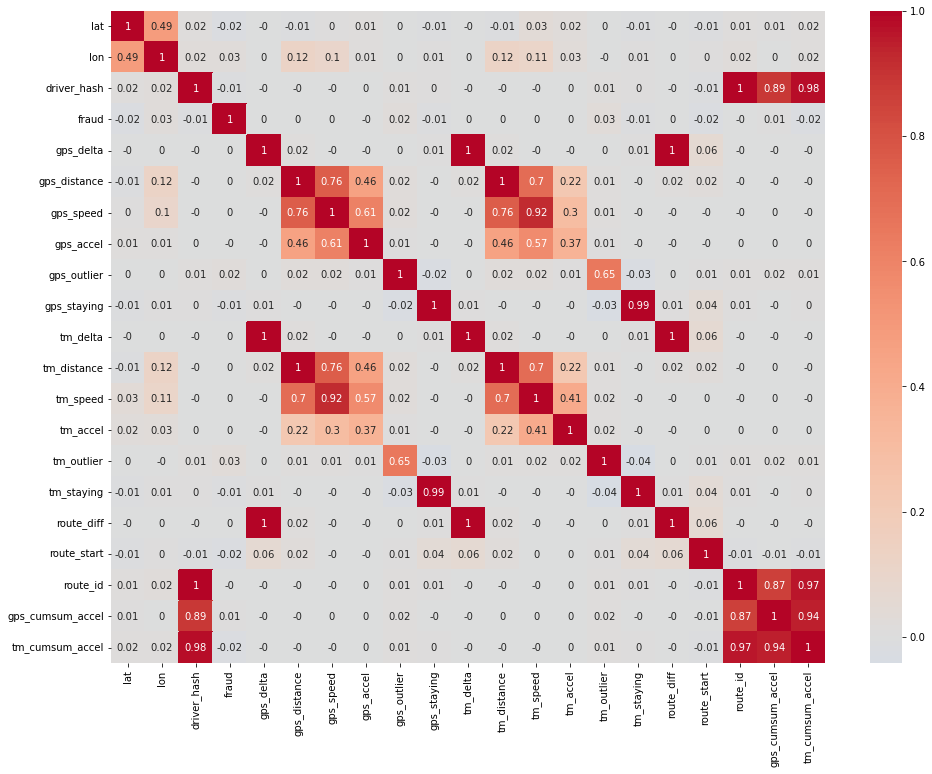

In [6]:
df_gps["gps_cumsum_accel"] = df_gps["gps_accel"].cumsum()
df_gps["tm_cumsum_accel"] = df_gps["tm_accel"].cumsum()

corr = df_gps.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

## Классификатор1

In [7]:
columns = [
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_cumsum_accel"
]

X = df_gps.loc[df_gps["fraud"] >= 0, columns].copy()
y = df_gps.loc[df_gps["fraud"] >= 0, "fraud"].copy()

display(f"Features/Target: {(X.shape, y.shape)}")

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(f"Train/Test: {(X_train.shape, y_train.shape, X_test.shape, y_test.shape)}")

clf_gps = RandomForestClassifier(n_jobs=-1)
clf_gps.fit(X_train, y_train)
proba = clf_gps.predict_proba(X_test)

imps = pd.Series(clf_gps.feature_importances_, X_train.columns).sort_values(ascending=False)
display(imps.rename("Importances").to_frame().T)

'Features/Target: ((1066109, 5), (1066109,))'

'Train/Test: ((799581, 5), (799581,), (266528, 5), (266528,))'

,gps_cumsum_accel,gps_delta,gps_accel,gps_speed,gps_distance
Importances,0.8785,0.043732,0.031986,0.022975,0.022807


Train    80631.0
Test     26904.0
Pred     26721.0
dtype: float64

accuracy_score    0.998135
f1_score          0.990732
dtype: float64

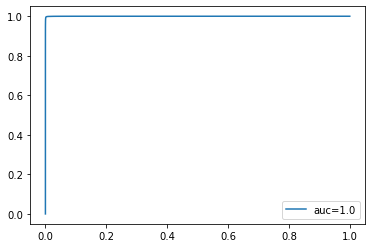

In [8]:
y_pred = pd.Series(proba.argmax(axis=1), index=X_test.index, name="Pred")
display(pd.concat((y_train.rename("Train"), y_test.rename("Test"), y_pred), axis=1).sum())

display(pd.Series((accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)),
                  index = ("accuracy_score", "f1_score")))

auc = roc_auc_score(y_test, proba[::,1])
fpr, tpr, _ = roc_curve(y_test,  proba[::,1])
plt.plot(fpr,tpr,label=f"auc={auc:.2}")
plt.legend(loc=4)
plt.show()

## Классификатор2

In [9]:
columns = [
    "tm_delta",
    "tm_distance",
    "tm_speed",
    "tm_accel",
    "tm_cumsum_accel"
]

X = df_gps.loc[df_gps["fraud"] >= 0, columns].copy()
y = df_gps.loc[df_gps["fraud"] >= 0, "fraud"].copy()

display(f"Features/Target: {(X.shape, y.shape)}")

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(f"Train/Test: {(X_train.shape, y_train.shape, X_test.shape, y_test.shape)}")

clf_tm = RandomForestClassifier(n_jobs=-1)
clf_tm.fit(X_train, y_train)
proba = clf_tm.predict_proba(X_test)

imps = pd.Series(clf_tm.feature_importances_, X_train.columns).sort_values(ascending=False)
display(imps.rename("Importances").to_frame().T)

'Features/Target: ((1066109, 5), (1066109,))'

'Train/Test: ((799581, 5), (799581,), (266528, 5), (266528,))'

,tm_cumsum_accel,tm_delta,tm_accel,tm_distance,tm_speed
Importances,0.896477,0.035358,0.028951,0.020298,0.018915


Train    80621.0
Test     26914.0
Pred     26867.0
dtype: float64

accuracy_score    0.999651
f1_score          0.998271
dtype: float64

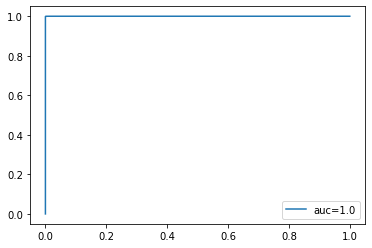

In [10]:
y_pred = pd.Series(proba.argmax(axis=1), index=X_test.index, name="Pred")
display(pd.concat((y_train.rename("Train"), y_test.rename("Test"), y_pred), axis=1).sum())

display(pd.Series((accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)),
                  index = ("accuracy_score", "f1_score")))

auc = roc_auc_score(y_test, proba[::,1])
fpr, tpr, _ = roc_curve(y_test,  proba[::,1])
plt.plot(fpr,tpr,label=f"auc={auc:.2}")
plt.legend(loc=4)
plt.show()

In [11]:
columns = [
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_cumsum_accel"
]

df_gps["gps_pred"] = clf_gps.predict(df_gps[columns])
df_gps["gps_pred"].value_counts()

0    3394326
1    1655966
Name: gps_pred, dtype: int64

In [12]:
columns = [
    "tm_delta",
    "tm_distance",
    "tm_speed",
    "tm_accel",
    "tm_cumsum_accel"
]

df_gps["tm_pred"] = clf_tm.predict(df_gps[columns])
df_gps["tm_pred"].value_counts()

0    3523103
1    1527189
Name: tm_pred, dtype: int64

In [13]:
df_gps[["gps_pred", "tm_pred"]].value_counts().sort_index()

gps_pred  tm_pred
0         0          3023886
          1           370440
1         0           499217
          1          1156749
dtype: int64

In [14]:
df_pred = df_gps \
    .groupby(by=["fraud", "driver_hash"]) \
    .agg({"gps_pred": "sum", "tm_pred": "sum", "fraud": "count"}) \
    .rename(columns={"fraud": "points"}) \
    .sort_index()

df_pred.tail(50)

gps_pred  tm_pred  points
fraud driver_hash                                    
-1     8441926883992743797         0        0   38528
       8472641716551984138         0       23    8475
       8484618983568667576        56       23   24589
       8495411695898023080        92        9   22783
       8708539809027958552        60       39   31907
       8799657288824140068         0       24   20439
       8894636921649230831         0        0   13871
       8921990331059051231         0        0   23350
       8979134000488028450         0        0   24378
       8979322487342770688         0        0    1060
       9028001926696043346         0        0   17144
       9142516420276355425         0        0    7481
       9206466041403273735         0        0   19370
 0    -8855449059095575743        47        0   44773
      -8285444573847573076         0        0   25396
      -4472006672024242679         6        1   36834
      -4294745953159109974        65        1   40827
      -4080393840523659459        11        3   41959
      -3754613297758316782        19        4   46659
      -2326108064915089301         3       14   22128
      -917569374742463282          1        0   85301
       50909632375203636           0        0   53188
       102237250308562244          0        0   55713
       254619638422759589          0        0   50866
       269342988796658819          0        0   44981
       631642712709916337          4        0   31776
       2339565149906962126         1        0   34398
       4633179079544742811         0        0   57838
       4792989220905314639         0        0   25243
       4805235792201203747         0        0   24202
       4957397998143787649         0        0   30327
       5900186570978300677         0        0   34018
       5960642249321857991         0        0   42616
       7363918686470073741         0        0   50682
       7934040023444826650         0        0   46228
       8893554023910460211         0        0   32621
 1    -8915411586673655243        51       54      55
      -8729475955540025841      3039     3085    3087
      -7745607963253656189     15994    15994   15994
      -7078426713190014901      1798     1799    1799
      -6715898809375179473     14877    14887   14887
      -4687681644253937266      1995     1995    1995
      -4385647888228392778      6126     6103    6131
      -3962756297262839169     11110    11103   11129
      -2988946964244641879      7755     7748    7755
      -2132251359044308970      7496     7748    7749
       1293535473153840726        17       17      17
       2025312357143911724     16948    16946   16948
       2765355583032989810     19965    19965   19965
       8569741546477592565        24       21      24

In [15]:
df_pred["gps_proba"] = df_pred["gps_pred"] / df_pred["points"]
df_pred["tm_proba"] = df_pred["tm_pred"] / df_pred["points"]
df_pred["fraud_gps"] = df_pred["gps_proba"].round(0).astype(int)
df_pred["fraud_tm"] = df_pred["tm_proba"].round(0).astype(int)
df_pred = df_pred.reset_index()
df_pred

,fraud,driver_hash,gps_pred,tm_pred,points,gps_proba,tm_proba,fraud_gps,fraud_tm
0,-1,-9218579406240981296,13578,13346,17592,0.771828,0.758640,1,1
1,-1,-9148378939849570226,1616,1671,2430,0.665021,0.687654,1,1
2,-1,-9090289600630456229,2997,2913,4458,0.672275,0.653432,1,1
3,-1,-9073383204587901813,9765,10386,12885,0.757858,0.806054,1,1
4,-1,-9067392653059450527,10669,7762,14939,0.714171,0.519580,1,1
...,...,...,...,...,...,...,...,...,...
312,1,-2132251359044308970,7496,7748,7749,0.967351,0.999871,1,1
313,1,1293535473153840726,17,17,17,1.000000,1.000000,1,1
314,1,2025312357143911724,16948,16946,16948,1.000000,0.999882,1,1
315,1,2765355583032989810,19965,19965,19965,1.000000,1.000000,1,1


In [16]:
df_pred["prod_proba"] = df_pred["gps_proba"] * df_pred["tm_proba"]
df_pred.sort_values(by="prod_proba", ascending=False).tail(50)

,fraud,driver_hash,gps_pred,tm_pred,points,gps_proba,tm_proba,fraud_gps,fraud_tm,prod_proba
118,-1,-1925347472299738945,3,0,14552,0.000206,0.0,0,0,0.0
128,-1,-1346464726589806952,0,0,9216,0.000000,0.0,0,0,0.0
119,-1,-1791105230299809808,2,0,16327,0.000122,0.0,0,0,0.0
120,-1,-1730031538596589542,8789,0,20892,0.420687,0.0,0,0,0.0
122,-1,-1646515189705073742,5673,0,6031,0.940640,0.0,1,0,0.0
123,-1,-1521954197117090226,9538,0,10448,0.912902,0.0,1,0,0.0
124,-1,-1492388485364258518,12774,0,16836,0.758731,0.0,1,0,0.0
125,-1,-1448444799159421921,19166,0,23419,0.818395,0.0,1,0,0.0
126,-1,-1390779379353637353,4587,0,6613,0.693634,0.0,1,0,0.0
149,-1,-160215043373707069,0,0,24378,0.000000,0.0,0,0,0.0


## Earlier submisstion

In [17]:
df_rf = pd.read_csv(f"{DATA_PATH}/submission_rf.csv")
df_rf.columns = ["driver_hash", "fraud_rf"]

df_cb = pd.read_csv(f"{DATA_PATH}/submission_catboost.csv")
df_cb.columns = ["driver_hash", "fraud_cb"]

df_submission = df_rf.merge(df_cb, on="driver_hash")
df_submission = df_pred.merge(df_submission, on="driver_hash")

df_submission[["fraud_gps", "fraud_tm", "fraud_rf", "fraud_cb"]].value_counts().sort_index()

fraud_gps  fraud_tm  fraud_rf  fraud_cb
0          0         0         0           49
                               1            8
                     1         0            1
                               1           82
           1         0         0            6
                               1            2
                     1         0            1
                               1           16
1          0         0         0           16
                               1            1
                     1         1           20
           1         0         0           24
                               1            5
                     1         1           49
dtype: int64

## Clustering

In [18]:
columns = [
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_cumsum_accel"
]

df_clust = df_gps[["fraud", "driver_hash"]].copy()

for i in range(2, 15):
    np.random.seed(100)
    
    clust = KMeans(n_clusters=i)
    clust.fit(df_gps[columns])
    
    labels = pd.Series(clust.labels_, df_gps.index, name=f"clusters{i}")
    
    l = labels.value_counts().rename("Points")
    l0 = labels[df_gps["fraud"] == 0].value_counts().rename("Good")
    l1 = labels[df_gps["fraud"] == 1].value_counts().rename("Fraud")
    display(pd.concat((l, l0, l1), axis=1).T)
    
    df_clust = pd.concat((df_clust, labels.to_frame()), axis=1)


,0,1
Points,5050266.0,26.0
Good,958561.0,13.0
Fraud,107535.0,NaN


,0,1,2
Points,3684578.0,26.0,1365688.0
Good,614790.0,13.0,343771.0
Fraud,107511.0,NaN,24.0


,0,1,2,3
Points,3684504.0,20.0,1365659.0,109.0
Good,614786.0,10.0,343766.0,12.0
Fraud,107509.0,NaN,23.0,3.0


,0,1,2,3,4
Points,1365649.0,3684461.0,16.0,152.0,14.0
Good,343766.0,614786.0,8.0,7.0,7.0
Fraud,23.0,107507.0,NaN,5.0,NaN


,0,1,2,3,4,5
Points,2269606.0,16.0,1365649.0,152.0,14.0,1414855.0
Good,343869.0,8.0,343766.0,7.0,7.0,270917.0
Fraud,70576.0,NaN,23.0,5.0,NaN,36931.0


,0,1,2,3,4,5,6
Points,2269596.0,1365649.0,10.0,12.0,1414852.0,163.0,10.0
Good,343869.0,343766.0,5.0,6.0,270917.0,6.0,5.0
Fraud,70576.0,23.0,NaN,NaN,36931.0,5.0,NaN


,0,1,2,3,4,5,6,7
Points,2269576.0,1365643.0,10.0,63.0,10.0,1414842.0,10.0,138.0
Good,343869.0,343766.0,5.0,7.0,5.0,270917.0,5.0,NaN
Fraud,70574.0,23.0,NaN,2.0,NaN,36930.0,NaN,6.0


,0,1,2,3,4,5,6,7,8
Points,1414842.0,10.0,994352.0,63.0,2269576.0,10.0,10.0,371291.0,138.0
Good,270917.0,5.0,188299.0,7.0,343869.0,5.0,5.0,155467.0,NaN
Fraud,36930.0,NaN,23.0,2.0,70574.0,NaN,NaN,NaN,6.0


,0,1,2,3,4,5,6,7,8,9
Points,1414841.0,10.0,994350.0,9.0,63.0,2269573.0,10.0,135.0,10.0,371291.0
Good,270917.0,5.0,188299.0,5.0,1.0,343869.0,5.0,NaN,6.0,155467.0
Fraud,36930.0,NaN,23.0,NaN,3.0,70574.0,NaN,5.0,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10
Points,1414842.0,9.0,994351.0,9.0,2269576.0,60.0,7.0,10.0,133.0,4.0,371291.0
Good,270917.0,5.0,188299.0,5.0,343869.0,1.0,3.0,6.0,NaN,2.0,155467.0
Fraud,36930.0,NaN,23.0,NaN,70574.0,3.0,NaN,NaN,5.0,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11
Points,371434.0,1046240.0,4.0,9.0,63.0,1955227.0,9.0,994207.0,135.0,7.0,10.0,682947.0
Good,155610.0,321820.0,2.0,5.0,1.0,258569.0,5.0,188156.0,NaN,3.0,6.0,34397.0
Fraud,NaN,5398.0,NaN,NaN,3.0,70574.0,NaN,23.0,5.0,NaN,NaN,31532.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
Points,1955213.0,7.0,994340.0,81.0,681846.0,9.0,9.0,371291.0,55.0,91.0,9.0,4.0,1047337.0
Good,258569.0,3.0,188299.0,NaN,34397.0,5.0,5.0,155467.0,2.0,1.0,5.0,2.0,321819.0
Fraud,70572.0,NaN,23.0,3.0,30432.0,NaN,NaN,NaN,2.0,5.0,NaN,NaN,6498.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Points,835977.0,7.0,994340.0,9.0,1187950.0,55.0,82.0,9.0,1081609.0,371291.0,9.0,4.0,578860.0,90.0
Good,270916.0,3.0,188299.0,5.0,116825.0,2.0,NaN,5.0,227044.0,155467.0,5.0,2.0,NaN,1.0
Fraud,16963.0,NaN,23.0,NaN,47619.0,2.0,3.0,NaN,22953.0,NaN,NaN,NaN,19967.0,5.0


In [19]:
df_clust.groupby(["fraud", "driver_hash"], sort=True).agg(set).tail(50)

clusters2 clusters3 clusters4 clusters5 clusters6  \
fraud driver_hash                                                              
-1     8441926883992743797       {0}       {2}       {2}       {0}       {2}   
       8472641716551984138       {0}       {2}       {2}       {0}       {2}   
       8484618983568667576       {0}       {2}       {2}       {0}       {2}   
       8495411695898023080       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       8708539809027958552       {0}       {2}       {2}       {0}       {2}   
       8799657288824140068       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       8894636921649230831    {0, 1}    {1, 2}    {2, 3}    {0, 4}    {2, 4}   
       8921990331059051231       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       8979134000488028450       {0}       {2}       {2}       {0}       {2}   
       8979322487342770688       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       9028001926696043346       {0}       {2}       {2}       {0}       {2}   
       9142516420276355425       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       9206466041403273735       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
 0    -8855449059095575743    {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 1}   
      -8285444573847573076       {0}       {0}    {0, 3}    {1, 4}    {0, 4}   
      -4472006672024242679    {0, 1}    {0, 1}    {0, 3}    {1, 4}    {0, 4}   
      -4294745953159109974    {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 1}   
      -4080393840523659459    {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 1}   
      -3754613297758316782       {0}       {0}    {0, 3}    {1, 3}    {0, 3}   
      -2326108064915089301       {0}       {0}    {0, 3}    {1, 3}    {0, 3}   
      -917569374742463282     {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 1}   
       50909632375203636      {0, 1}    {0, 1}    {0, 1}    {1, 4}    {4, 5}   
       102237250308562244        {0}       {0}    {0, 3}    {1, 4}    {4, 5}   
       254619638422759589     {0, 1}    {0, 1}    {0, 1}    {1, 2}    {1, 5}   
       269342988796658819        {0}       {0}       {0}       {1}       {5}   
       631642712709916337     {0, 1}    {0, 1}    {0, 1}    {1, 2}    {1, 5}   
       2339565149906962126    {0, 1}    {0, 1}    {0, 3}    {1, 4}    {4, 5}   
       4633179079544742811    {0, 1}    {1, 2}    {1, 2}    {0, 2}    {1, 2}   
       4792989220905314639       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       4805235792201203747       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       4957397998143787649       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       5900186570978300677       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       5960642249321857991       {0}       {2}    {2, 3}    {0, 3}    {2, 3}   
       7363918686470073741    {0, 1}    {1, 2}    {1, 2}    {0, 2}    {1, 2}   
       7934040023444826650    {0, 1}    {1, 2}    {1, 2}    {0, 4}    {2, 4}   
       8893554023910460211    {0, 1}    {1, 2}    {2, 3}    {0, 4}    {2, 4}   
 1    -8915411586673655243       {0}       {0}       {0}       {1}       {0}   
      -8729475955540025841       {0}       {0}       {0}    {1, 3}    {0, 3}   
      -7745607963253656189       {0}       {0}       {0}       {1}       {0}   
      -7078426713190014901       {0}       {0}    {0, 3}    {1, 3}    {0, 3}   
      -6715898809375179473       {0}       {0}       {0}       {1}       {0}   
      -4687681644253937266       {0}       {0}       {0}       {1}       {0}   
      -4385647888228392778       {0}       {0}       {0}       {1}       {0}   
      -3962756297262839169       {0}       {0}       {0}       {1}    {0, 5}   
      -2988946964244641879       {0}       {0}       {0}       {1}       {0}   
      -2132251359044308970       {0}       {0}    {0, 3}    {1, 3}    {0, 3}   
       1293535473153840726       {0}       {0}       {0}    {1, 3}    {3, 5}   
       2025312357143911724       {0}       {0}       {0}       {1}       {5}   
       2765355583032989810 

## Visialization

In [28]:
# [None, -1, 0, 1]
FORCE_FRAUD = None

# Выбор случайного водителя
driver_gps, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
driver_gps = driver_gps.sort_values(by="gps_time").reset_index(drop=True)

gps_pred = driver_gps[driver_gps["gps_pred"] == 1]
tm_pred = driver_gps[driver_gps["tm_pred"] == 1]

center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

# Маршрут по данным  GPS
map_driver_points(m, driver_gps, driver_hash, label="gps")

fg = folium.FeatureGroup(f"gps_pred {gps_pred.shape[0]}/{driver_gps.shape[0]}").add_to(m)
for i, r in tqdm(gps_pred.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="red")).add_to(fg)

fg = folium.FeatureGroup(f"tm_pred {tm_pred.shape[0]}/{driver_gps.shape[0]}").add_to(m)
for i, r in tqdm(tm_pred.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="purple")).add_to(fg)

folium.map.LayerControl('topleft', collapsed= False).add_to(m)
m

2it [00:00, 374.09it/s]
1it [00:00, 414.42it/s]
